In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spikeinterface.extractors as se
import matplotlib.colors as mcolors
from numpy.random import multivariate_normal

from scipy import signal
from scipy.signal import kaiserord,butter, lfilter, firwin

ns_rec 320
ns 10000000


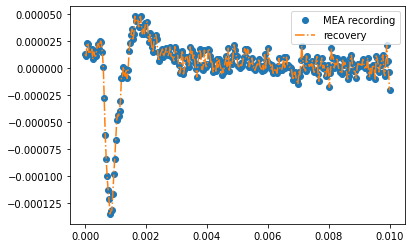

In [2]:
from scipy.fft import fft, ifft, fftshift

# Toy example0: A neuron spike captured by MEA simulated
# by MEArec and sampled by 32kHz.
rec, _ = se.read_mearec('data/MEA10*10/recgen_cell_10/0.h5')
recording= rec.get_traces()
tsim = 10e-3 # simulation time
#recording simulation time 
fs_rec= 32000 # sampling frequency of recordings
ns_rec= round(tsim*fs_rec)
ts_rec= np.linspace(0, tsim, ns_rec)
print('ns_rec', ns_rec)
#vlc simulation time
fs= 1e9 # sampling frequency of vcl
ns= round(tsim*fs) # number of samples for vcl
ts= np.linspace(0, tsim, ns) 
print('ns', ns)
#interpolating recording
start= 3830
end= start+ns_rec
electrodeuV = recording[start:end,0]/1e6
electrodeV1 = np.interp(ts, ts_rec, electrodeuV) # interpolating the 32kHz signal to get .1GHz sampling frequency

plt.plot(ts_rec, electrodeuV, 'o', label='MEA recording')
plt.plot(ts, electrodeV1, '-.', label='recovery')
plt.legend()


In [3]:
# Following the VCO formalism, This function gets sign(phi-pi) or the oscillations
def osc(ev, f0, k0, tsim, fs):
    ns= round(fs*tsim)
    fc= f0*np.cumsum(np.ones(ns))
    fv= k0*np.cumsum(ev)
    phic=2*np.pi*fc*(1/fs)
    phiv=2*np.pi*fv*(1/fs)
    delta_phi=phic+phiv 
    phi= delta_phi%(2*np.pi)
    osc= phi>np.pi
    return osc

# This function gives the oscillations, identified rising and falling edges
# and droped a random amount of edges (for example between 30 to 50 edges) and kept
# the ground truth of skipped pulses
def rsamp(ts, osc):
    edg = np.diff(osc&1)
    risingedges= np.where(edg==1)[0]
    fallingedges= np.where(edg==-1)[0]
    low_bound_skipped=30
    up_bound_skipped=50
    NPulses_tobeSkipped = np.random.randint(low_bound_skipped, 
                                            up_bound_skipped, 
                                            size=len(risingedges)-1,
                                            dtype=int)
    aux2 = NPulses_tobeSkipped[np.cumsum(NPulses_tobeSkipped)<len(risingedges)-2]
    GT_NumberOfPulsesSkipped = np.append(aux2, len(risingedges)-2-np.sum(aux2))
    GT_NumberOfPulsesSkipped = np.append(GT_NumberOfPulsesSkipped, 1)
    selected_risingedges = np.append(risingedges[0],
                                     risingedges[np.cumsum(GT_NumberOfPulsesSkipped)])
    selected_risingedges_times= ts[selected_risingedges]
    risingedges_times= ts[risingedges]
    return risingedges_times, selected_risingedges_times, GT_NumberOfPulsesSkipped

# This fucntion build a dataset with potential periods between each two measured pulses
# (two pulses after dropping a random value between them) and followed Vitirbi algorithm 
# to solve HMM. The out put is reconstructed number of skipped pulses and periods
def vitirbi(selected_risingedges_times, f0, k0):
    maxNrec = int(np.ceil(max(np.diff(selected_risingedges_times))*f0))
    AllN = np.arange(1,maxNrec)
    l= len(np.diff(selected_risingedges_times))
    PotentialPeriods = np.zeros((len(AllN), l))

    for i,e in enumerate(AllN):
        PotentialPeriods[i,:]= np.diff(selected_risingedges_times)/e
        
    T1_min = np.zeros((len(AllN),l))
    T2_index = np.zeros((len(AllN),l))
    rec3_maxperiod = 1/(f0 - k0*30e-3)
    rec3_minperiod = 1/(f0 + k0*30e-3)
    
    for ii in range(1,l):
        for jj in range(len(AllN)):
            val= abs(PotentialPeriods[jj,ii]- PotentialPeriods[:,ii-1]) + T1_min[:,ii-1]
            T1_min[jj,ii] =  np.min(val) 
            T2_index[jj,ii] = np.argmin(val)


    T1_min_final = np.min(abs(T1_min[:,-1]))
    T2_index_final = np.argmin(abs(T1_min[:,-1]))
    Z = np.zeros(l)
    rec3_periods = np.zeros(l)
    rec3_N = np.zeros(l)

    Z[-1] = T2_index_final
    rec3_periods[-1] = PotentialPeriods[int(Z[-1]),-1]
    rec3_N[-1] = AllN[int(Z[-1])]

    for ii in range(l-1,0,-1):
        Z[ii-1] = T2_index[int(Z[ii]),ii]
        rec3_periods[ii-1] = PotentialPeriods[int(Z[ii-1]),ii-1]
        rec3_N[ii-1] = AllN[int(Z[ii-1])]
    return rec3_N, rec3_periods

# This function applies the recovery of signal with reconstructed pulses and compare it
# with the ground truth.
def recover(rec3_N, selected_risingedges_times, f0, k0):
    Reconstructed_numberofSkippedPulses= rec3_N
    TimeElapsedBetweenTimestamps= np.diff(selected_risingedges_times)
    Reconstructed_OscillationFrequency = 1/(TimeElapsedBetweenTimestamps/Reconstructed_numberofSkippedPulses)
    Reconsructed_electrodeV= (Reconstructed_OscillationFrequency -f0)/k0
    tvector_forReconstructedSignal= (selected_risingedges_times[:-1]+selected_risingedges_times[1:])/2
    return Reconsructed_electrodeV, tvector_forReconstructedSignal

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (.5*fs)
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

### Stochastic amplitude and frequency point for white noise

In [4]:
# randomly choose a frequency between flow and fup
flow = 3 # in logspace -> 1e2
fup= 5 # in logspace -> 1e5
niter=5000
fc= np.random.choice(np.logspace(flow, fup, niter), size=niter)
# original signal sampling frequenct fs and simulated time ts
tsim=10e-3
fs=1e9
ns= round(tsim*fs)
ts= np.linspace(0, tsim, ns) 

# central frequenct fo and gain k0 of the voltage control oscillator
f0= 2e6 
k0= 20*f0 

# choose a random amplitude from a normal distribution
ampllow= -4 # in logspace -> 1e-5
amplup= -2 # in logspace -> 1e-2
g= np.random.RandomState(seed=12345)
ampl= np.random.choice(np.logspace(ampllow, amplup, niter), size=niter)
#ampl= abs(g.normal(loc=0.0, scale=.03, size=niter))

# generate niter number of random singnals
plabel=[]
nlabel=[]
vvt=[]
vvr=[]
for a, f in zip(ampl, fc):
    
    s= g.normal(loc=0.0, scale=1, size=ns)
    # low-pass filter the random gaussian noise
    sf= butter_lowpass_filter(s, f, fs, 1)
    # tune the banded noise with amplitude
    sig = a*sf
    #sig = a*np.sin(2*np.pi*f*t_vlc)
    
    v0= osc(sig, f0, k0, tsim, fs)
    ret, sret, gt_nsp= rsamp(ts, v0)
    recn, _= vitirbi(sret, f0, k0)
    vt, _= recover(gt_nsp, sret, f0, k0)
    vvt.append(vt)
    vr, _= recover(recn, sret, f0, k0)
    vvr.append(vr)
    if np.array_equal(vt, vr):
        plabel.append([a, f, 1])
    else:
        nlabel.append([a, f, 0])

d= np.append(plabel, nlabel, axis=0)    

<Figure size 864x432 with 0 Axes>

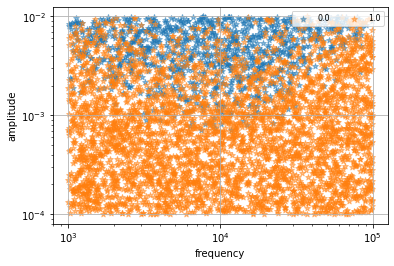

In [5]:
plt.figure(figsize=(12,6))
d= np.append(plabel, nlabel, axis=0)
plt.figure()
labels=d[:,-1]
ind_l = np.unique(labels)
legend = []
for i,label in enumerate(ind_l):
    ind = np.where(label==labels)[0]
    plot = plt.scatter(d[ind,1], d[ind,0],alpha=0.5, marker='*')
    legend.append(plot)
plt.legend(ind_l,scatterpoints=1,numpoints=1,prop={'size':8},ncol=6,loc="upper right",fancybox=True)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("frequency")
plt.ylabel("amplitude")
plt.grid(True)

In [6]:
# # hist plot from scratch
# import matplotlib.cm as cm
# from matplotlib.ticker import MultipleLocator
# # This import registers the 3D projection, but is otherwise unused.
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# binx, biny= 10, 10
# xl = np.logspace(-5,-2, binx)
# yl = np.logspace(3,5, biny)
# ap = d[np.where(d[:,2]==1)[0],0]
# fp = d[np.where(d[:,2]==1)[0],1]
# an = d[np.where(d[:,2]==0)[0],0]
# fn = d[np.where(d[:,2]==0)[0],1]
# cp=np.zeros((binx,biny))
# cn=np.zeros((binx,biny))

# for i in range(len(xl)-1):
#     for j in range(len(yl)-1):
#         for a,f in zip(ap,fp):
#             if xl[i]<=a<xl[i+1] and yl[j]<=f<yl[j+1]:
#                 cp[i,j] +=1

# for i in range(len(xl)-1):
#     for j in range(len(yl)-1):
#         for a,f in zip(an,fn):
#             if xl[i]<=a<xl[i+1] and yl[j]<=f<yl[j+1]:
#                 cn[i,j] +=1

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))
# ax.zaxis.set_major_locator(MultipleLocator(2))

# width = depth = .1

# for i in range(len(xl)-1):
#     for j in range(len(yl)-1):
#         ax.bar3d(np.log10(xl[i]), np.log10(yl[j]), 0, width, depth, cp[i,j], edgecolor = 'black', alpha=.8)
# plt.show()

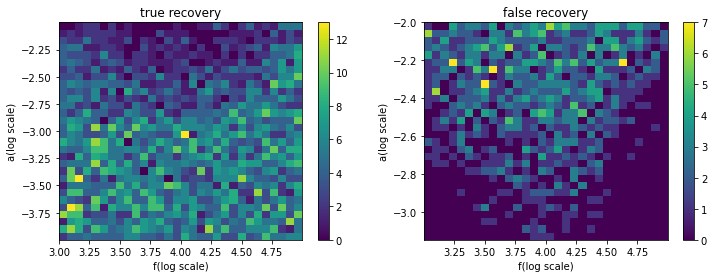

In [7]:
ap = d[np.where(d[:,2]==1)[0],0]
fp = d[np.where(d[:,2]==1)[0],1]
an = d[np.where(d[:,2]==0)[0],0]
fn = d[np.where(d[:,2]==0)[0],1]

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist2d(np.log10(fp), np.log10(ap), bins=30)
plt.xlabel('f(log scale)')
plt.ylabel('a(log scale)')
plt.title('true recovery')
plt.colorbar()
plt.subplot(122)
plt.hist2d(np.log10(fn), np.log10(an), bins=30)
plt.xlabel('f(log scale)')
plt.ylabel('a(log scale)')
plt.title('false recovery')
plt.colorbar()

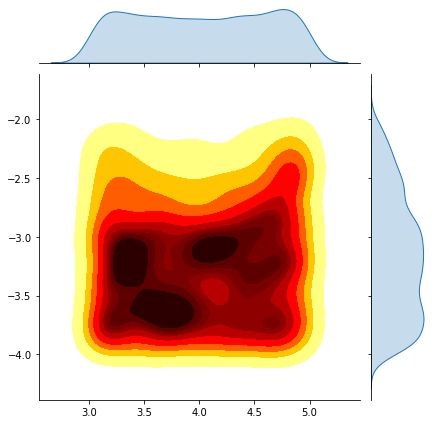

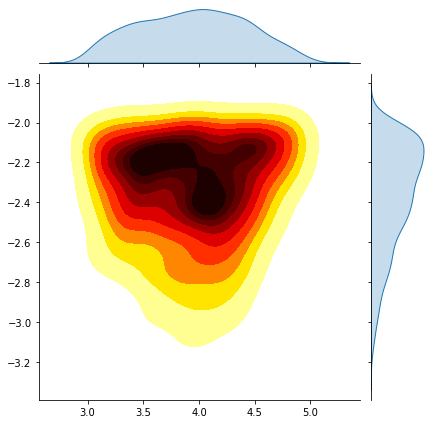

In [8]:
sns.jointplot(x=np.log10(fp), y=np.log10(ap), kind='kde', cmap='hot_r', n_levels=10, fill=True)
sns.jointplot(x=np.log10(fn), y=np.log10(an), kind='kde', cmap='hot_r', n_levels=10, fill=True)

### Test one point:

Text(0.5, 1.0, 'electrodeV: fs= 1000000000.0, ns= 10000000')

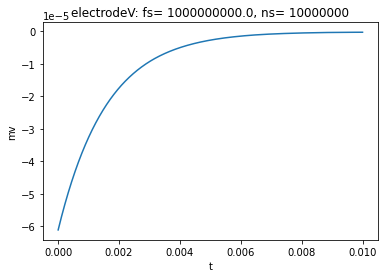

In [9]:
# simulation time
tsim = 10e-3 

# vco 
fs= 1e9 # sampling frequency of vcl
ns= round(tsim*fs) # number of samples for vcl
ts= np.linspace(0, tsim, ns)

f=1e2
a=1e-4

# #sinusoid
#electrodeV= a*np.sin(2*np.pi*f*ts)

#random
s= g.normal(loc=0.0, scale=1, size=ns)
sf= butter_lowpass_filter(s, f, fs, 1)
electrodeV = a*sf

plt.plot(ts, electrodeV)
plt.ylabel('mv')
plt.xlabel('t')
plt.title('electrodeV: fs= %s, ns= %s'%(fs,ns))

In [10]:
f0= 2e6
k0= 20*f0
v0= osc(electrodeV, f0, k0, tsim, fs)
ret, sret, gt_nsp= rsamp(ts, v0)
vt, _= recover(gt_nsp, sret, f0, k0)
recn, _= vitirbi(sret, f0, k0)
vr, _ = recover(recn, sret, f0, k0)

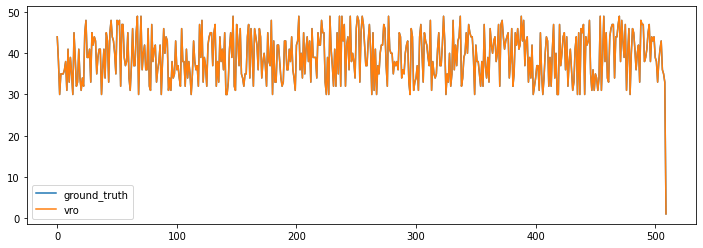

In [11]:
plt.figure(figsize=(12,4))
plt.plot(gt_nsp, label='ground_truth')
plt.plot(recn, label='vro')
plt.legend()

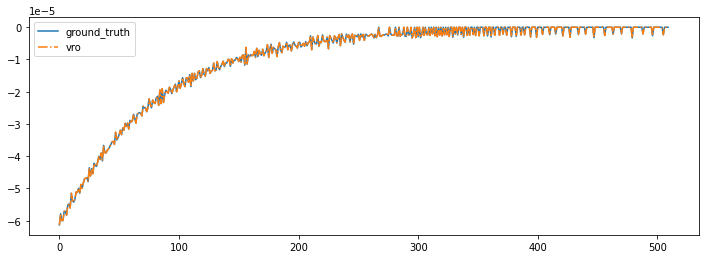

In [12]:
plt.figure(figsize=(12,4))
plt.plot(vt, label='ground_truth')
plt.plot(vr,'-.', label='vro')
plt.legend()

### Deterministc amplitude and frequency point for random noise

In [20]:
flow= 3
fup= 5
niter= 70
fc= np.logspace(flow, fup, niter)
# original signal sampling frequenct fs and simulated time ts
tsim=10e-3
fs=1e9
ns= round(tsim*fs)
ts= np.linspace(0, tsim, ns) 

# central frequenct fo and gain k0 of the voltage control oscillator
f0= 2e6 
k0= 20*f0 

# choose a random amplitude from a normal distribution
ampllow= -4 # in logspace -> 1e-5
amplup= -2 # in logspace -> 1e-2
g= np.random.RandomState(seed=12345)
ampl= np.logspace(ampllow, amplup, niter)
#ampl= abs(g.normal(loc=0.0, scale=.03, size=niter))

# generate niter number of random singnals
plabel=[]
nlabel=[]
vvt=[]
vvr=[]
recnt=[]
recnf=[]
for a in ampl:
    for f in fc:
        
        # random signal
        s= g.normal(loc=0.0, scale=1, size=ns)
        sf= butter_lowpass_filter(s, f, fs, 1)
        sig = a*sf
        
        # sinusoid
        #sig = a*np.sin(2*np.pi*f*ts)

        v0= osc(sig, f0, k0, tsim, fs)
        ret, sret, gt_nsp= rsamp(ts, v0)
        recn, _= vitirbi(sret, f0, k0)
        if np.array_equal(gt_nsp, recn):
            plabel.append([a, f, 1])
            recnt.append((recn,gt_nsp,sret))
        else:
            nlabel.append([a, f, 0])
            recnf.append((recn,gt_nsp,sret))

d_det= np.append(plabel, nlabel, axis=0)    

a:  0.0006927550656129393 f:  24620.924014946257


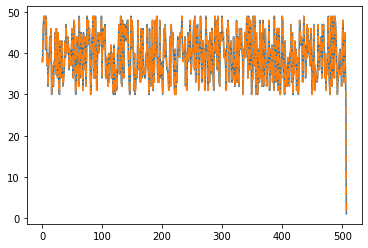

In [21]:
sn=1
spr,spt, sr=recnf[sn]
print('a: ',nlabel[sn][0], 'f: ',nlabel[sn][1])
plt.plot(spt)
plt.plot(spr,'-.')

In [22]:
np.where(spr!=spt)[0]

array([0])

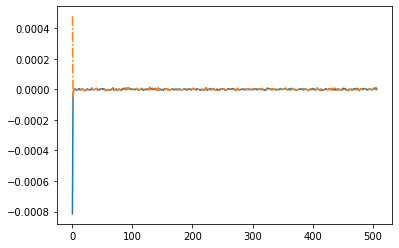

In [23]:
vt, _= recover(spt, sr, f0, k0)
vr, _= recover(spr, sr, f0, k0)
plt.plot(vt)
plt.plot(vr,'-.')

In [24]:
np.where(vr!=vt)[0]

array([0])

<Figure size 864x432 with 0 Axes>

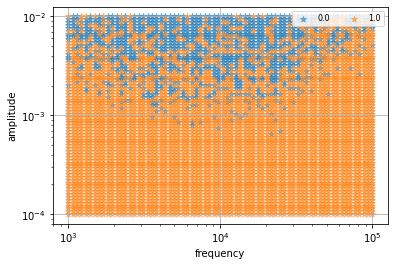

In [25]:
plt.figure(figsize=(12,6))
d_det= np.append(plabel, nlabel, axis=0) 
plt.figure()
labels=d_det[:,-1]
ind_l = np.unique(labels)
legend = []
for i,label in enumerate(ind_l):
    ind = np.where(label==labels)[0]
    plot = plt.scatter(d_det[ind,1], d_det[ind,0],alpha=0.5, marker='*')
    legend.append(plot)
plt.legend(ind_l,scatterpoints=1,numpoints=1,prop={'size':8},ncol=6,loc="upper right",fancybox=True)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("frequency")
plt.ylabel("amplitude")
plt.grid(True)

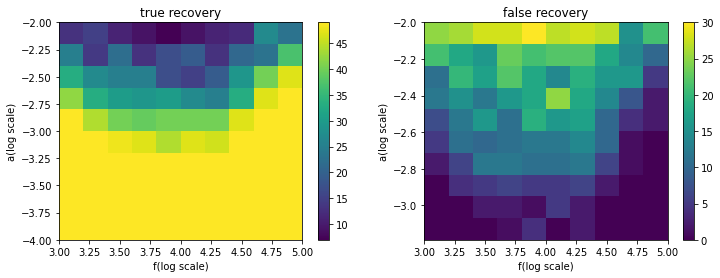

In [26]:
ap = d_det[np.where(d_det[:,2]==1)[0],0]
fp = d_det[np.where(d_det[:,2]==1)[0],1]
an = d_det[np.where(d_det[:,2]==0)[0],0]
fn = d_det[np.where(d_det[:,2]==0)[0],1]

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist2d(np.log10(fp), np.log10(ap), bins=10)
plt.xlabel('f(log scale)')
plt.ylabel('a(log scale)')
plt.title('true recovery')
plt.colorbar()
plt.subplot(122)
plt.hist2d(np.log10(fn), np.log10(an), bins=10)
plt.xlabel('f(log scale)')
plt.ylabel('a(log scale)')
plt.title('false recovery')
plt.colorbar()